In [7]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from time import sleep

import numpy as np
from numpy.random import seed
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from IPython import display
seed(42)
sns.set_style('white')
cmap = ListedColormap(sns.xkcd_palette(['denim blue', 'medium green', 'pale red']))
cmap = ListedColormap(sns.color_palette('Paired', 10))

In [8]:
# 2D Cluster Demo
def sample_clusters(n_points=500, n_dimensions=2, n_clusters=5, cluster_std=1):
    return make_blobs(n_samples=n_points, n_features=n_dimensions, centers=n_clusters,
                      cluster_std=cluster_std, random_state=42)

In [9]:
# Evaluate Number of Clusters using Inertia
def inertia_plot_update(inertias, ax, delay=1):
    inertias.plot(color='k', lw=1, title='Inertia', ax=ax, xlim=(inertias.index[0], inertias.index[-1]),
                  ylim=(0, inertias.max()))
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    sleep(delay)

def plot_kmeans_result(data, labels, centroids, assignments, ncluster, Z, ax):
    # plot data
    ax.scatter(*data.T, c=labels, s=20, cmap=cmap)

    # plot cluster centers
    ax.scatter(*centroids.T, marker='o', c='w', s=200, edgecolor='k', zorder=9)

    for i, c in enumerate(centroids):
        ax.scatter(*c, marker=f'${i}$', s=50, edgecolor=['k'], zorder=10)
        xy = pd.DataFrame(data[assignments == i], columns=['x', 'y']).assign(cx=c[0], cy=c[1])
        ax.plot(xy[['x', 'cx']].T.values, xy[['y', 'cy']].T.values, ls='--', color='k', lw=0.5)

    # plot voronoi
    ax.imshow(Z, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap=cmap,
              aspect='auto', origin='lower', alpha=.2)
    ax.set_title(f'Number of Clusters: {ncluster}')
    plt.tight_layout()

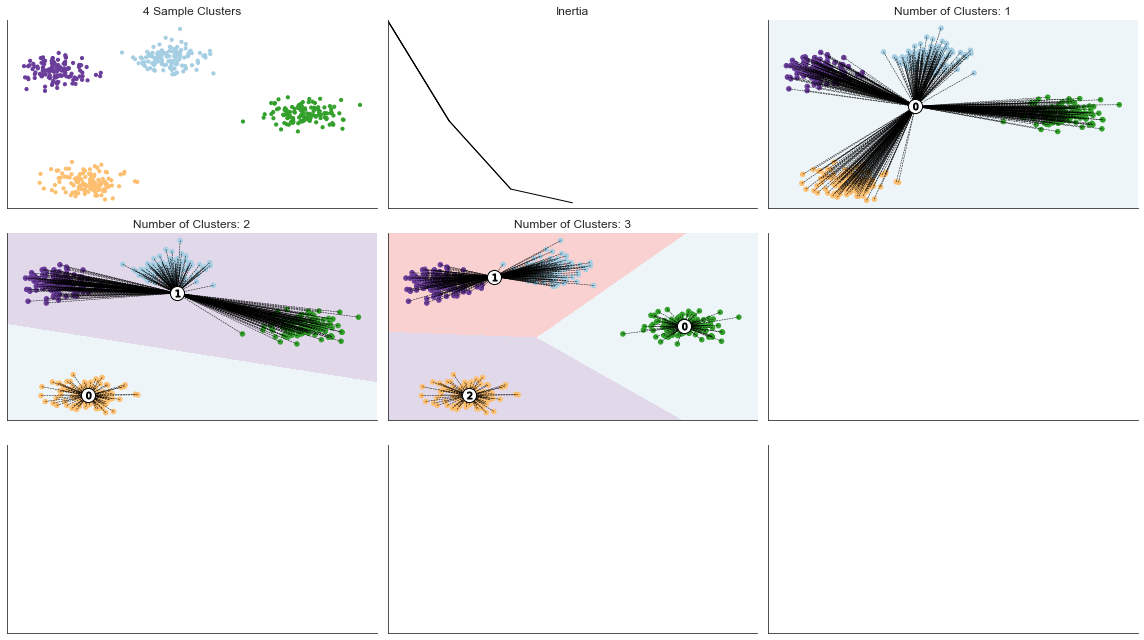

In [ ]:
# Run Elbow Experiment
n_clusters, max_clusters = 4, 7
cluster_list = list(range(1, max_clusters + 1))
inertias = pd.Series(index=cluster_list)
data, labels = sample_clusters(n_clusters=n_clusters)
x, y = data.T
xx, yy = np.meshgrid(np.arange(x.min() - 1, x.max() + 1, .01), np.arange(y.min() - 1, y.max() + 1, .01))
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(16, 9))
axes = np.array(axes).flatten()

# Plot Sample Data
axes[0].scatter(x, y, c=labels, s=10, cmap=cmap)
axes[0].set_title('{} Sample Clusters'.format(n_clusters))
for ax in axes:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
sns.despine();

for c, n_clusters in enumerate(range(1, max_clusters + 1), 2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(data)
    centroids, assignments, inertia = kmeans.cluster_centers_, kmeans.labels_, kmeans.inertia_
    inertias[n_clusters] = inertia
    inertia_plot_update(inertias, axes[1])
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plot_kmeans_result(data, labels, centroids, assignments,  n_clusters, Z, axes[c])
fig.tight_layout()

In [ ]:
# Evaluating the Silhouette Score
def plot_silhouette(values, y_lower, i, n_cluster, ax):
    cluster_size = values.shape[0]
    y_upper = y_lower + cluster_size

    color = plt.cm.viridis(i / n_cluster)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, values, facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * cluster_size, str(i))
    y_lower = y_upper + 10
    return y_lower

def format_silhouette_plot(ax):
    ax.set_title("Silhouette Plot")
    ax.set_xlabel("Silhouette Coefficient")
    ax.set_ylabel("Cluster Label")
    ax.axvline(x=silhouette_avg, color='red', linestyle='--', lw=1)
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

def plot_final_assignments(x, y, centroids, assignments, n_cluster, ax):
    c = plt.cm.viridis(assignments / n_cluster)
    ax.scatter(x, y, marker='.', s=30, lw=0, alpha=0.7, c=c, edgecolor='k')
    ax.scatter(*centroids.T, marker='o', c='w', s=200, edgecolor='k')
    for i, c in enumerate(centroids):
        ax.scatter(*c, marker='${}$'.format(i), s=50, edgecolor='k')
    ax.set_title('{} Clusters'.format(n_cluster))

n_clusters = 4
max_clusters = 7
cluster_list = list(range(1, max_clusters + 1))
inertias = pd.Series(index=cluster_list)
data, labels = sample_clusters(n_clusters=n_clusters)
x, y = data.T
fig, axes = plt.subplots(ncols=2, nrows=max_clusters, figsize=(12, 20))

axes[0][0].scatter(x, y, c=labels, s=10, cmap=cmap)
axes[0][0].set_title('Sample Clusters')

for i in range(max_clusters):
    for j in [0, 1]:
        axes[i][j].axes.get_xaxis().set_visible(False)
        axes[i][j].axes.get_yaxis().set_visible(False)
sns.despine()

for row, n_cluster in enumerate(range(2, max_clusters + 1), 1):
    kmeans = KMeans(n_clusters=n_cluster, random_state=42).fit(data)
    centroids, assignments, inertia = (kmeans.cluster_centers_, kmeans.labels_, kmeans.inertia_)
    inertias[n_cluster] = inertia
    inertia_plot_update(inertias, axes[0][1])

    silhouette_avg = silhouette_score(data, assignments)
    silhouette_values = silhouette_samples(data, assignments)
    silhouette_plot, cluster_plot = axes[row]

    y_lower = 10
    for i in range(n_cluster):
        y_lower = plot_silhouette(np.sort(silhouette_values[assignments == i]), y_lower, i, n_cluster,
                                  silhouette_plot)
    format_silhouette_plot(silhouette_plot)
    plot_final_assignments(x, y, centroids, assignments, n_cluster, cluster_plot)
    fig.tight_layout()

fig.suptitle(f'KMeans Silhouette Plot with {n_clusters} Clusters', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.95)